## Analyzing In sample model analysis with deeper level analysis of confusion matrix

In [1]:
%matplotlib inline

In [2]:
import json

from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_momentum_studies import TALibMomentumStudies
from Code.lib.model_utils import ModelUtility, TimeSeriesSplitImproved
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os.path
import pickle

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Load issue data and set date range
Pivot date is last date and time segments calculated by OOS months and IS-OOS ratio

In [5]:
plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibMomSt = TALibMomentumStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
    
issue = "TLT"
# Set IS-OOS parameters
pivotDate = datetime.date(2018, 4, 2)
is_oos_ratio = 3
oos_months = 4
segments = 2

dataSet = dSet.read_issue_data(issue)

# get first data from loaded data instead of hard coding start date
dataSet = dSet.set_date_range(dataSet, "2014-09-26", pivotDate)

#set beLong level
beLongThreshold = 0.000
dataSet = ct.setTarget(dataSet, "Long", beLongThreshold)

Successfully retrieved data series for TLT


### Set features
Features should be normalized...

In [6]:
input_dict = {} # initialize
input_dict = {'f1': 
          {'fname' : 'ATR', 
           'params' : [5],
           'transform' : ['Normalized', 50]
           },
          'f2': 
          {'fname' : 'RSI', 
           'params' : [2],
           'transform' : ['Normalized', 50]
           },
          'f3': 
          {'fname' : 'DeltaATRRatio', 
           'params' : [2, 10],
           'transform' : ['Scaler', 'robust']
           }
         }    
dataSet2 = featureGen.generate_features(dataSet, input_dict)

f1
Current feature:  ATR_5
transform:  ['Normalized', 50]
f2
Current feature:  RSI_2
transform:  ['Normalized', 50]
f3
Current feature:  DeltaATRratio_S2_L10
transform:  ['Scaler', 'robust']


### Load processing dates for IS and OOS; set start date for model analysis

In [7]:
# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = is_start_date
modelEndDate = modelStartDate + relativedelta(months=is_months)
print("Issue: " + issue)
print("Start date: " + str(modelStartDate) + "  End date: " + str(modelEndDate))


predictor_vars = "Temp holding spot"

                    Segments:  2
                IS OOS Ratio:  3
                  OOS months:  4
                   IS Months:  12
              Months to load:  28
              Data Load Date:  2016-07-02
              IS Start  Date:  2016-08-02
              OOS Start Date:  2017-08-02
                  Pivot Date:  2018-04-02
Issue: TLT
Start date: 2016-08-02  End date: 2017-08-02


### Split data for analysis and make a copy for Expected Value calcs

In [8]:
mmData = dataSet[modelStartDate:modelEndDate].copy()
nrows = mmData.shape[0]

# EV related
evData = dataSet[modelStartDate:modelEndDate].copy()


### Plot data under analysis

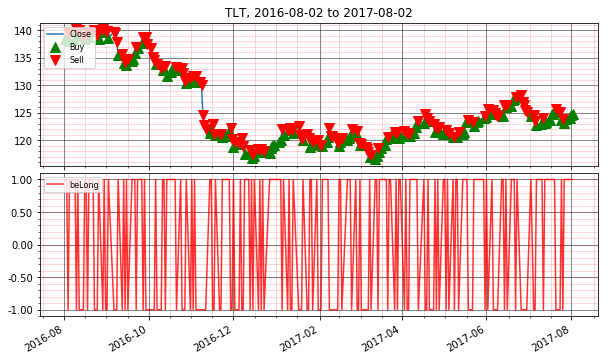

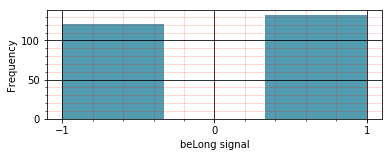

In [9]:
plotTitle = issue + ", " + str(modelStartDate) + " to " + str(modelEndDate)
plotIt.plot_v2x(mmData, plotTitle)
plotIt.histogram(mmData['beLong'],
                 x_label="beLong signal",
                 y_label="Frequency",
                 title = "beLong distribution for " + issue
                 )        
plt.show(block=False)

### Evaluation stationarity of Close

In [10]:
stationarity_tests(mmData, 'Close', issue)


====== ADF Test for Stationarity for  Close =======
Issue:  TLT
Start Date:  2016-08-02
End Date:  2017-08-02

ADF Statistic: -1.842918
p-value: 0.359372
** The series is likely non-stationary **
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

====== Hurst Exponent Test ======
Hurst(GBM):   0.506
Hurst(MR):    -0.001
Hurst(TR):    0.916
Hurst(TLT):   0.496


### Evaluate stationarity of features


In [11]:
#stationarity_tests(mmData, 'Close', issue)

cols = [k for k,v in feature_dict.items() if v == 'Keep']
for x in cols:
    stationarity_tests(mmData, x, issue)


====== ADF Test for Stationarity for  ATR_5_Normalized =======
Issue:  TLT
Start Date:  2016-08-02
End Date:  2017-08-02

ADF Statistic: -3.587153
p-value: 0.006011
** The series is likely stationary **
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

====== Hurst Exponent Test ======
Hurst(GBM):   0.503
Hurst(MR):    -0.000
Hurst(TR):    0.910
Hurst(TLT):   0.496

====== ADF Test for Stationarity for  RSI_2_Normalized =======
Issue:  TLT
Start Date:  2016-08-02
End Date:  2017-08-02

ADF Statistic: -6.392331
p-value: 0.000000
** The series is likely stationary **
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573

====== Hurst Exponent Test ======
Hurst(GBM):   0.504
Hurst(MR):    0.001
Hurst(TR):    0.914
Hurst(TLT):   0.072

====== ADF Test for Stationarity for  DeltaATRratio_S2_L10_Scaled =======
Issue:  TLT
Start Date:  2016-08-02
End Date:  2017-08-02

ADF Statistic: -9.620492
p-value: 0.000000
** The series is likely stationary **
Critical Values:
	1%: -3.457
	5%: -2.8

### Select features to drop including OHL, gainAhead, symbol, Date, Close

In [12]:
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Symbol', 'Date', 'Close']
for x in to_drop:
    col_vals.append(x)
mmData = dSet.drop_columns(mmData, col_vals)

### Plot correlation matrix
Improve this to identify and drop features with corr value higher than 0.3
Look at other methods to identify features and their contribution

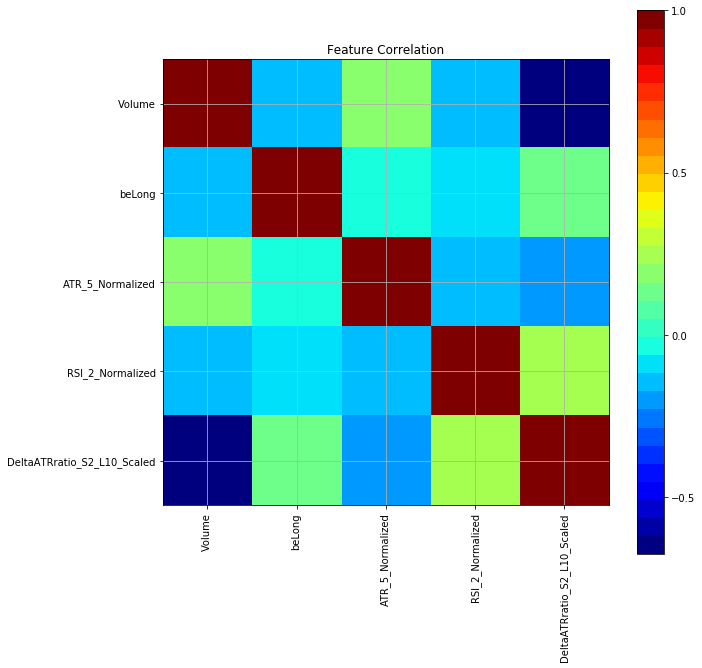

In [13]:
plotIt.correlation_matrix(mmData)

### Function to define CM results and details of other measures
Organize by most important
##### Accuracy (also Rate of Correctness)
Percentage of accurate predictions
##### Precision
Positive predicted value(PPV)
#### Rate of Missing Chances (RMC)
FN / # of true instances
#### Rate of Failure (RF)
FP / # positive instances 
##### MCC 
In essence a correlation coefficient between the observed and predicted binary classifications.
It returns a value between −1 and +1. 
A coefficient of +1 represents a perfect prediction.
0 no better than random prediction.
−1 indicates total disagreement between prediction and observation.

##### Recall (also Sensitivity, Hit Rate, True Positive Rate (TPR))
Proportion of actual positives that are correctly identified
##### Specificity (also called Selectivity, True Negative Rate (TNR))
Proportion of actual negatives that are correctly identified

##### Negative Predicted Value (NPV)



In [14]:
def conf_matrix_results(cm_results):
    import math
    return_cm = ()
    tp = cm_results[1,1]
    fn = cm_results[1,0]
    fp = cm_results[0,1]
    tn = cm_results[0,0]
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    accuracy = (tp + tn)/(tp + fn + fp + tn)
    specificity = tn/(tp+tn)
    rmc = fn/(fn+tp)
    rf = fp/(fp + tp)
    npv = tn/(tn+fn)
    f1 = (2.0 * precision * recall) / (precision + recall)
    mcc = ((tp*tn) - (fp*fn))/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    return_cm = (precision, recall, accuracy, f1)
    
    print('{0:>30} {1:2.2f}'.format("Accuracy: ", accuracy))
    print('{0:>30} {1:2.2f}'.format("Precision (PPV): ", precision))
    print('{0:>30} {1:2.2f}'.format("Rate of Missing Chances: ", rmc))
    print('{0:>30} {1:2.2f}'.format("Rate of Failure: ", rf))
    
    print('{0:>30} {1:2.2f}'.format("Neg Pred Value (NPV): ", npv))
    print('{0:>30} {1:2.2f}'.format("MCC: ", mcc))

    return return_cm

#### Function for Confusion Matrix Plot
Print CM for totals and percentages

In [15]:
def cm_plot(cm, type):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title(type + ' beLong Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            # counts
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j])+"\n")
            # percentage of total
            plt.text(j,i, str('{:.2%}'.format(cm[i][j]/cm.sum())))
    plt.show()

#### Get average gain/loss from beLong signals
Across data set, sum gainAhead and count number signals to provide an average gain (mutiply * 100 to get %)

In [16]:
def get_evData_avg(evData, signal):
    # sum gainAhead of signals
    ev_sum = evData.loc[evData['beLong'] == signal, 'gainAhead'].sum()
    ev_cnt = evData.loc[evData['beLong'] == signal, 'beLong'].count()
    ev_avg = ev_sum/ev_cnt
    return ev_avg

#### Expected Value
Associate the confusion matrix with an expected value using a cost benefit analysis matrix.
1. Get probabilities for the confusion matrix
2. Retrieve the average returns for the confusion matrix. In this case, the only returns that affect the expected value are the:
    * Average gains for TP
    * Average losses for FP
    * 0 loss used for TN, and FN (FN is a missed opportunity, but no loss)
3. Multiply and CB and CM probabilities

In [17]:
def find_expected_value(cm, cost_benefit):
    # if you use a probability matrix instead, this next line will return the same matrix back
    #print("CB\n", cost_benefit)
    probabilities = cm / cm.sum()
    #print("Probabilities:\n", probabilities)
    ev = probabilities * cost_benefit
    #print("EV array:\n", ev)
    return ev.sum()

In [18]:
######################
# ML section
######################
#  Make 'iterations' index vectors for the train-test split
iterations = 100
tscv = TimeSeriesSplit(n_splits=10)

dX, dy = modelUtil.prepare_for_classification(mmData)        

sss = StratifiedShuffleSplit(n_splits=iterations,
                             test_size=0.33,
                             random_state=None
                             )

tscv = TimeSeriesSplit(n_splits=6, max_train_size=24)

predictor_vars = "convert info_dict to columns to insert"
model_results = []

#### 8 different classification algorithms

* Decision tree
* RandomForest - Ensemble method
* XGBoost
* SVM (Support Vector Machine) Classifier
* Nearest Neighbors Classifier
* SGD (Stochastic Gradient Descent) classifier
* Gaussian Naive Bayes
* MLP (Multi-layer Perceptron) Neural network

In [19]:
def setRFClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = RandomForestClassifier(n_jobs=-1,
                                   random_state=55,
                                   oob_score = 'TRUE',
                                   **parameters
                                   )
    print(model)
    return model

In [20]:
def setKNNClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = KNeighborsClassifier(**parameters)
    print(model)
    return model

In [21]:
def setSVMClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = svm.SVC(shrinking=False,
                    random_state=0,
                    gamma='scale',
                    **parameters
                   )
    print(model)
    return model

In [22]:
def setAdaBoostClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=10),
                               **parameters
                               )
    print(model)
    return model

In [23]:
def setGTBClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = GradientBoostingClassifier(**parameters)
    print(model)
    return model

In [24]:
def setQDAClass(**parameters):
    if parameters is not None:
        params_used = parameters
    model = QuadraticDiscriminantAnalysis(**parameters)
    print(model)
    return model

In [27]:
modelname = "RF"
model = setRFClass(min_samples_split=20, n_estimators=200)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score='TRUE', random_state=55, verbose=0, warm_start=False)


In [28]:
modelname = "KNN"
model = setKNNClass(n_neighbors=5)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


In [29]:
modelname = "SVM"
model = setSVMClass()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=False,
  tol=0.001, verbose=False)


In [30]:
modelname = "AdaBoost"
model = setAdaBoostClass(learning_rate=0.2, n_estimators=500)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=500, random_state=None)


In [31]:
modelname = "Gradient Tree Boosting"
model = setGTBClass(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [32]:
modelname = "Quadratic Discriminant Analysis"
model = setQDAClass()

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)


In [33]:
to_model = {"RF": setRFClass(min_samples_split=20, n_estimators=200), 
            "KNN": setKNNClass(n_neighbors=5)}
for key, value in to_model.items():
    modelname = key
    info_dict = {'issue':issue, 'modelStartDate':modelStartDate, 'modelEndDate':modelEndDate, 'modelname':modelname, 'nrows':nrows}
    model_results = modelUtil.model_and_test(dX, dy, model, model_results, sss, info_dict, evData)
print(model_results)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score='TRUE', random_state=55, verbose=0, warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


NameError: name 'model_test' is not defined

----------------------
==In Sample==


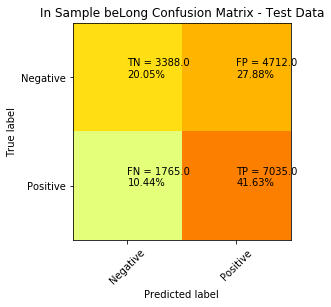

                    Accuracy:  0.62
             Precision (PPV):  0.60
     Rate of Missing Chances:  0.20
             Rate of Failure:  0.40
        Neg Pred Value (NPV):  0.66
                         MCC:  0.24
              Expected Value:  0.035%


----------------------
==Out of Sample==


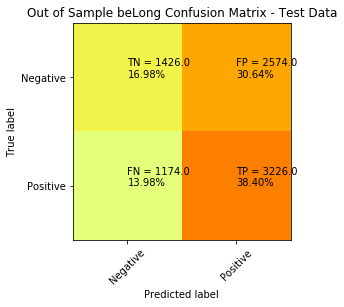

                    Accuracy:  0.55
             Precision (PPV):  0.56
     Rate of Missing Chances:  0.27
             Rate of Failure:  0.44
        Neg Pred Value (NPV):  0.55
                         MCC:  0.10
              Expected Value:  0.002%


[{'Issue': 'TLT', 'StartDate': '2016-08-02', 'EndDate': '2017-08-02', 'Model': 'RF', 'Rows': 253, 'beLongCount': '132', 'Features': ['ATR_5_Normalized', 'RSI_2_Normalized', 'DeltaATRratio_S2_L10_Scaled'], 'IS-Accuracy': 0.6167455621301775, 'IS-Precision': 0.59950190477831133, 'IS-Recall': 0.79943181818181808, 'IS-F1': 0.68420974188700368, 'IS-EV': 0.034936464401530726, 'OOS-Accuracy': 0.55380952380952364, 'OOS-Precision': 0.55631216879085377, 'OOS-Recall': 0.73318181818181816, 'OOS-F1': 0.63072876107606002, 'OOS-EV': 0.0024340730987808343}]


In [38]:
### add issue, other data OR use dictionary to pass data!!!!!!

info_dict = {'issue':issue, 'modelStartDate':modelStartDate, 'modelEndDate':modelEndDate, 'modelname':modelname, 'nrows':nrows,}
model_results = modelUtil.model_and_test(dX, dy, model, model_results, sss, info_dict, evData)
print(model_results)